In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta

from matplotlib import font_manager, rc, cm
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

import glob
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from tqdm.notebook import tqdm
from pycaret.regression import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
#! pip install pycaret

In [3]:
input_file = r'C:\Users\ghdwl\OneDrive\바탕 화면\날씨 콘테스트\data'
beatuy_label = pd.read_csv(os.path.join(input_file,'beauty_label_6.csv'))
food_label = pd.read_csv(os.path.join(input_file,'food_label_7.csv'))
electric_label = pd.read_csv(os.path.join(input_file,'elec_label_5.csv'))

sns_data = pd.read_csv(os.path.join(input_file,'sns_data 이상치 대체.csv'))
climate_data = pd.read_csv(os.path.join(input_file,'climate_data_date_스케일링전.csv'),encoding='utf-8')

all_file_list = glob.glob(os.path.join(input_file, 'buy_data*'))
all_data = [] 

for file in all_file_list:
    df = pd.read_csv(file) 
    all_data.append(df)
    
buy_data = pd.concat(all_data, axis=0, ignore_index=True)

In [4]:
climate_data = climate_data.set_index('date')

del climate_data['week'], climate_data['day']

climate_data['강수계급'] = climate_data['강수계급'].agg(lambda x: 0 if x == '무강수' else 1 if x == '0.1mm이상 1mm미만' 
                         else 2 if x == '1mm이상 10mm미만' else 3 if x == '10mm이상 30mm미만' else 4)

climate_data['바람계급'] = climate_data['바람계급'].agg(lambda x: 0 if x == '0.5m/s이상 3.4m/s미만' else 1)

climate_data['구름계급'] = climate_data['구름계급'].agg(lambda x : 0 if x == '맑음' else 1 if x == '구름조금' 
                                                else 2 if x == '구름많음' else 3)

In [5]:
buy_data = buy_data.iloc[:,1:]
sns_data = sns_data.iloc[:,2:]

In [6]:
beatuy_label = beatuy_label.rename(columns = {'소분류' : 'sm_cat'})
food_label = food_label.rename(columns = {'소분류' : 'sm_cat'})
electric_label = electric_label.rename(columns = {'소분류' : 'sm_cat'})

# merge를 위해 label 데이터프레임 생성
label =  pd.concat([beatuy_label, food_label, electric_label], axis = 0)  

In [7]:
new = pd.merge(buy_data, sns_data, on = ['date','big_cat','sm_cat'], how = 'inner')
new_label = pd.merge(new, label, on = ['sm_cat'], how= 'inner')

## 구매 군집_ beauty04_모델 : 스킨케어 마스크팩
- 참고사항:data = example.pivot_table(index = 'date', columns = ['sm_cat'], values = 'qty', aggfunc = 'sum',fill_value =0)

In [8]:

#example = new_label.query('big_cat == "식품" and labels ==1') # 별표(big_cat / label / sm_cat 추가)
example = new_label.query('big_cat == "뷰티" and sm_cat == "스킨케어 마스크팩"')
example['age'] = example['age'].agg(lambda x: str(x) + "대")
example = example[['qty','date','sex','age']]

#example = pd.concat([example, pd.get_dummies(example['sex'])], axis=1)
#example = pd.concat([example, pd.get_dummies(example['age'])], axis =1)

#example = example[['date','F','M','20대','30대','40대','50대','60대','qty']]

example['qty'] = example['qty'].fillna(0)

In [9]:
#del example['sm_cat']

In [10]:
climate_date_04 = climate_data[['최저기온', '최고기온', 'rain', '평균풍속', '평균상대습도', '평균현지기압', '평균증기압',
                                '합계일조시간', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'tenrain', 'weekend', '실효습도', '기온편차']]

# 해당 클러스터 중에서 높은 R값 가지는 걸 기준을 계절 삼고 거기에 들어가는 날짜 변수 넣기 

In [11]:
climate_date_04.rename(columns={'최저기온':'min temperature', '최고기온':'max temperature', '평균풍속' : 'avg wind speed', 
                                '합계일조시간' : 'sum sunshine time', '평균상대습도' : 'avg relative humidity', 
                                '평균현지기압' : 'avg local pressure', '평균증기압' : 'avg vapor pressure', '실효습도' : 'effective humidity', 
                                '기온편차' : 'temperature dev'},inplace=True)

In [12]:
climate_date_04.reset_index()
climate_date_04 = climate_date_04.reset_index()
example_beauty_04 = pd.merge(example, climate_date_04, on = 'date', how= 'left')

In [13]:
example_beauty_04['date'] = pd.to_datetime(example_beauty_04['date'])
example_beauty_04['월'] = example_beauty_04['date'].dt.month

In [14]:
beauty_04_category = example_beauty_04.query('월 == 3 or 월 == 4 or 월 == 10') # 계절에 맞게 월 == 숫자 변경
del beauty_04_category['월']

In [15]:
beauty_04_category = beauty_04_category.set_index('date')

In [16]:
beauty_04_category.shape

(1834, 20)

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(beauty_04_category.iloc[:,1:], beauty_04_category.iloc[:,0], 
                                                    test_size=0.2, shuffle=True, random_state=0)
train = pd.concat([x_train, y_train], axis = 1)

In [18]:
train.shape

(1467, 20)

In [19]:
from pycaret.regression import *
reg = setup(data=train,
            target='qty',
            numeric_imputation = 'mean',
            normalize = True,
            normalize_method = 'zscore',
            categorical_features = ['age','sex','weekend'],
            silent= True,
            fold_strategy = 'timeseries',
            fold = 3,
            session_id = 0)

,Description,Value
0,session_id,0
1,Target,qty
2,Original Data,"(1467, 20)"
3,Missing Values,False
4,Numeric Features,16
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1026, 23)"


In [20]:
best_5_d = compare_models(sort = 'R2', n_select = 3)
print(best_5_d)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,18.6413,890.9537,29.8194,0.7975,0.5136,0.5267,0.7267
lightgbm,Light Gradient Boosting Machine,19.4167,918.5091,30.2919,0.7913,0.5230,0.5216,2.8033
rf,Random Forest Regressor,18.9372,979.0013,31.2816,0.7781,0.3984,0.3794,2.2467
et,Extra Trees Regressor,19.1740,1034.3219,32.1498,0.7659,0.4037,0.3801,0.9667
ada,AdaBoost Regressor,26.9019,1316.3473,36.2606,0.7016,0.7143,1.1050,0.3233
lasso,Lasso Regression,28.5867,1483.4170,38.5064,0.6646,0.8679,1.4837,7.7733
br,Bayesian Ridge,29.6685,1497.8672,38.6965,0.6612,0.8983,1.6476,0.0367
ridge,Ridge Regression,29.8091,1501.7884,38.7470,0.6603,0.9007,1.6778,9.1733
lr,Linear Regression,29.9419,1508.4890,38.8327,0.6587,0.8948,1.7032,15.3600
dt,Decision Tree Regressor,24.2245,1620.4465,40.2294,0.6336,0.5143,0.4874,0.1267


[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, re

#### 모델 튜닝

'''params = {"max_depth": np.random.randint(1,40, 1),
          "max_features": np.random.randint(1,40, 1),
          "min_samples_leaf": [1,2,3,4,5,6,7,8],
          "min_samples_split" : [1,2,3,4,5,6],
           "max_leaf_nodes" : np.random.randint(3,15, 1),
          "n_estimators" :  np.random.randint(100,700, 1),
          "random_state" : [0]
         }'''


In [21]:
tuned_models = []

In [22]:
### Gradient Boosting 튜닝

model_gbr = create_model('gbr')# 상위 3개

model_gbr = tune_model(model_gbr, fold= 3, n_iter = 500, optimize = 'R2', verbose = True, choose_better = True)
tuned_models.append(model_gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,18.9261,905.9157,30.0984,0.7937,0.4540,0.4274
1,17.2256,793.0397,28.1610,0.8340,0.4256,0.4032
2,17.6023,884.5446,29.7413,0.7852,0.4021,0.3780
Mean,17.9180,861.1667,29.3336,0.8043,0.4273,0.4028
SD,0.7292,48.9568,0.8419,0.0213,0.0212,0.0202


In [23]:
# Light Gradient Boosting Machine 튜닝
model_lgbm = create_model('lightgbm') #상위 3개 

model_lgbm= tune_model(model_lgbm, fold= 3, n_iter = 500, optimize = 'R2', verbose = True, choose_better = True)
tuned_models.append(model_lgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,20.1585,866.2845,29.4327,0.8027,0.5880,0.6180
1,18.4780,800.7054,28.2967,0.8324,0.5083,0.5204
2,17.9237,876.9197,29.6128,0.7870,0.4485,0.4694
Mean,18.8534,847.9699,29.1141,0.8074,0.5149,0.5359
SD,0.9502,33.7019,0.5826,0.0188,0.0571,0.0616


In [24]:
# Random Forest 튜닝
model_rf = create_model('rf') #상위 3개 

model_rf= tune_model(model_rf, fold= 3, n_iter = 500, optimize = 'R2', verbose = True, choose_better = True)
tuned_models.append(model_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,19.3724,951.4155,30.8450,0.7833,0.3895,0.3744
1,19.0697,971.1294,31.1629,0.7967,0.3979,0.3652
2,16.8566,873.5780,29.5564,0.7878,0.3691,0.3370
Mean,18.4329,932.0410,30.5214,0.7893,0.3855,0.3589
SD,1.1214,42.1157,0.6947,0.0056,0.0121,0.0159


### 예측

In [25]:
prediction_models = []

- 배깅

In [26]:
bag_gbr_15 = ensemble_model(model_gbr, n_estimators = 15, fold=3, optimize = 'R2')
prediction_models.append(bag_gbr_15)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,18.5962,858.1374,29.2940,0.8045,0.4641,0.4981
1,17.5815,809.5715,28.4530,0.8305,0.4027,0.4136
2,17.2055,869.2998,29.4839,0.7889,0.3983,0.3858
Mean,17.7944,845.6696,29.0769,0.8080,0.4217,0.4325
SD,0.5874,25.9288,0.4480,0.0172,0.0300,0.0477


In [27]:
bag_lgbm_15 = ensemble_model(model_lgbm, n_estimators = 15, fold=3, optimize = 'R2')
prediction_models.append(bag_lgbm_15)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,19.4652,901.2078,30.0201,0.7947,0.5349,0.5865
1,18.9895,839.3032,28.9707,0.8243,0.5188,0.5492
2,17.7618,878.5310,29.6400,0.7866,0.4657,0.4935
Mean,18.7388,873.0140,29.5436,0.8019,0.5065,0.5431
SD,0.7177,25.5717,0.4338,0.0162,0.0295,0.0382


In [28]:
bag_rf_15 = ensemble_model(model_rf, n_estimators = 15, fold=3, optimize = 'R2')
prediction_models.append(bag_rf_15)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,19.8939,1009.3177,31.7698,0.7701,0.4192,0.4259
1,18.7606,934.2308,30.5652,0.8044,0.3874,0.3598
2,16.9481,935.1648,30.5805,0.7729,0.3642,0.3310
Mean,18.5342,959.5711,30.9718,0.7825,0.3903,0.3723
SD,1.2132,35.1782,0.5643,0.0156,0.0226,0.0397


- 부스팅

In [29]:
boo_gbr = ensemble_model(model_gbr, method = 'Boosting', fold=3, optimize='R2')
prediction_models.append(boo_gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,18.9222,921.9692,30.3639,0.7900,0.4365,0.4592
1,17.9861,897.2798,29.9546,0.8122,0.4312,0.4077
2,17.5124,894.3545,29.9058,0.7828,0.4003,0.3833
Mean,18.1402,904.5345,30.0748,0.7950,0.4227,0.4167
SD,0.5858,12.3859,0.2054,0.0125,0.0160,0.0317


In [30]:
boo_lgbm = ensemble_model(model_lgbm, method = 'Boosting', fold=3, optimize='R2')
prediction_models.append(boo_lgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,21.6364,938.0479,30.6276,0.7863,0.6220,0.7682
1,19.6884,880.8147,29.6785,0.8156,0.6107,0.6958
2,20.0073,956.1269,30.9213,0.7678,0.5381,0.6653
Mean,20.4440,924.9965,30.4091,0.7899,0.5903,0.7098
SD,0.8531,32.1012,0.5304,0.0197,0.0372,0.0432


In [31]:
boo_rf = ensemble_model(model_rf, method = 'Boosting', fold=3, optimize='R2')
prediction_models.append(boo_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,19.8872,954.3366,30.8923,0.7826,0.4670,0.5231
1,19.0022,939.8054,30.6562,0.8033,0.4104,0.4175
2,18.3755,1011.6827,31.8070,0.7543,0.3887,0.3838
Mean,19.0883,968.6082,31.1185,0.7801,0.4220,0.4415
SD,0.6202,31.0306,0.4963,0.0201,0.0330,0.0593


- Blending
- blend_models(estimator_list: list, fold: Optional[Union[int, Any]] = None, round: int = 4, choose_better: bool = False, optimize: str = 'Accuracy', method: str = 'auto', weights: Optional[List[float]] = None, fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True)

blend_3_soft = bl

In [32]:
blend_3_soft = blend_models(estimator_list=[model_lgbm, model_gbr, model_rf], fold=3, optimize='R2')
prediction_models.append(blend_3_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,17.9693,833.5074,28.8705,0.8101,0.4334,0.3911
1,17.2412,781.1121,27.9484,0.8365,0.4007,0.3839
2,16.3537,821.6884,28.6651,0.8004,0.3558,0.3321
Mean,17.1881,812.1027,28.4947,0.8157,0.3966,0.3690
SD,0.6607,22.4385,0.3953,0.0152,0.0318,0.0263


- 스태킹
stack_models(estimator_list: list, meta_model=None, fold: Optional[Union[int, Any]] = None, round: int = 4, method: str = 'auto', restack: bool = True, choose_better: bool = False, optimize: str = 'Accuracy', fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True) → Any

In [33]:
prediction_models

[BaggingRegressor(base_estimator=GradientBoostingRegressor(alpha=0.9,
                                                           ccp_alpha=0.0,
                                                           criterion='friedman_mse',
                                                           init=None,
                                                           learning_rate=0.05,
                                                           loss='ls',
                                                           max_depth=9,
                                                           max_features=1.0,
                                                           max_leaf_nodes=None,
                                                           min_impurity_decrease=0.2,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=3,
                                                           min_samples_spl

In [34]:
for model in tuned_models:
    print(model.__class__.__name__)
    display(predict_model(model))

GradientBoostingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,15.2202,577.5315,24.0319,0.8535,0.3987,0.3933


,min temperature,max temperature,rain,avg wind speed,avg relative humidity,avg local pressure,avg vapor pressure,sum sunshine time,SO2,CO,...,temperature dev,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_주말,qty,Label
0,-1.012523,-1.963418,-0.211980,2.751799,-0.838885,0.906986,-1.159441,-1.137735,-1.099166,-1.450313,...,0.467671,1.0,0.0,1.0,0.0,0.0,0.0,0.0,55.0,56.059140
1,-1.728643,-2.385929,-0.344444,2.751799,-0.679695,-1.595765,-1.297727,0.453171,-0.437616,0.206651,...,1.390829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,76.0,120.639404
2,0.644575,0.038911,-0.267945,0.916872,-0.171342,-0.128510,0.246283,-0.238525,-0.794368,-0.799044,...,0.069305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,105.0,93.324801
3,-0.282249,-0.002364,-0.496007,-0.559742,-0.147859,0.758771,-0.289506,0.841587,-0.914990,-1.016182,...,-2.005661,1.0,0.0,0.0,1.0,0.0,0.0,1.0,30.0,57.233579
4,0.198741,0.787545,-0.491219,-0.403583,-0.012591,-0.583572,0.318181,0.840972,0.146139,-0.489711,...,-0.712740,1.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,8.992246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,-1.070963,-1.643871,-0.395455,1.509963,0.253986,1.384000,-0.818685,-0.781636,-0.972296,-0.927625,...,1.658226,1.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,34.146319
437,0.025932,-0.027538,0.830123,-0.076709,0.430151,0.404622,0.027009,0.004430,-0.784175,-0.460666,...,0.283557,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,5.774932
438,0.123408,0.724271,-0.525634,-0.995389,-0.180576,0.492651,-0.034696,0.961313,-0.520923,-0.713669,...,0.441781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,4.825457
439,-0.594767,-1.142212,-0.132901,1.856952,0.026281,-1.013075,-0.689026,-0.271955,-0.825291,-0.429029,...,1.534010,1.0,1.0,0.0,0.0,0.0,0.0,1.0,27.0,22.109818


LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,15.3077,513.4955,22.6604,0.8697,0.4525,0.5261


,min temperature,max temperature,rain,avg wind speed,avg relative humidity,avg local pressure,avg vapor pressure,sum sunshine time,SO2,CO,...,temperature dev,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_주말,qty,Label
0,-1.012523,-1.963418,-0.211980,2.751799,-0.838885,0.906986,-1.159441,-1.137735,-1.099166,-1.450313,...,0.467671,1.0,0.0,1.0,0.0,0.0,0.0,0.0,55.0,43.530502
1,-1.728643,-2.385929,-0.344444,2.751799,-0.679695,-1.595765,-1.297727,0.453171,-0.437616,0.206651,...,1.390829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,76.0,81.137652
2,0.644575,0.038911,-0.267945,0.916872,-0.171342,-0.128510,0.246283,-0.238525,-0.794368,-0.799044,...,0.069305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,105.0,118.184858
3,-0.282249,-0.002364,-0.496007,-0.559742,-0.147859,0.758771,-0.289506,0.841587,-0.914990,-1.016182,...,-2.005661,1.0,0.0,0.0,1.0,0.0,0.0,1.0,30.0,49.722928
4,0.198741,0.787545,-0.491219,-0.403583,-0.012591,-0.583572,0.318181,0.840972,0.146139,-0.489711,...,-0.712740,1.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,9.446915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,-1.070963,-1.643871,-0.395455,1.509963,0.253986,1.384000,-0.818685,-0.781636,-0.972296,-0.927625,...,1.658226,1.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,35.937732
437,0.025932,-0.027538,0.830123,-0.076709,0.430151,0.404622,0.027009,0.004430,-0.784175,-0.460666,...,0.283557,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,5.189476
438,0.123408,0.724271,-0.525634,-0.995389,-0.180576,0.492651,-0.034696,0.961313,-0.520923,-0.713669,...,0.441781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,-2.690745
439,-0.594767,-1.142212,-0.132901,1.856952,0.026281,-1.013075,-0.689026,-0.271955,-0.825291,-0.429029,...,1.534010,1.0,1.0,0.0,0.0,0.0,0.0,1.0,27.0,23.233386


RandomForestRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,14.9529,621.1740,24.9234,0.8424,0.3563,0.3449


,min temperature,max temperature,rain,avg wind speed,avg relative humidity,avg local pressure,avg vapor pressure,sum sunshine time,SO2,CO,...,temperature dev,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_주말,qty,Label
0,-1.012523,-1.963418,-0.211980,2.751799,-0.838885,0.906986,-1.159441,-1.137735,-1.099166,-1.450313,...,0.467671,1.0,0.0,1.0,0.0,0.0,0.0,0.0,55.0,61.625
1,-1.728643,-2.385929,-0.344444,2.751799,-0.679695,-1.595765,-1.297727,0.453171,-0.437616,0.206651,...,1.390829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,76.0,64.600
2,0.644575,0.038911,-0.267945,0.916872,-0.171342,-0.128510,0.246283,-0.238525,-0.794368,-0.799044,...,0.069305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,105.0,105.175
3,-0.282249,-0.002364,-0.496007,-0.559742,-0.147859,0.758771,-0.289506,0.841587,-0.914990,-1.016182,...,-2.005661,1.0,0.0,0.0,1.0,0.0,0.0,1.0,30.0,27.850
4,0.198741,0.787545,-0.491219,-0.403583,-0.012591,-0.583572,0.318181,0.840972,0.146139,-0.489711,...,-0.712740,1.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,16.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,-1.070963,-1.643871,-0.395455,1.509963,0.253986,1.384000,-0.818685,-0.781636,-0.972296,-0.927625,...,1.658226,1.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,31.025
437,0.025932,-0.027538,0.830123,-0.076709,0.430151,0.404622,0.027009,0.004430,-0.784175,-0.460666,...,0.283557,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,4.450
438,0.123408,0.724271,-0.525634,-0.995389,-0.180576,0.492651,-0.034696,0.961313,-0.520923,-0.713669,...,0.441781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,10.225
439,-0.594767,-1.142212,-0.132901,1.856952,0.026281,-1.013075,-0.689026,-0.271955,-0.825291,-0.429029,...,1.534010,1.0,1.0,0.0,0.0,0.0,0.0,1.0,27.0,32.125


In [35]:
for model in prediction_models:
    print(model.__class__.__name__)
    display(predict_model(model))

BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,13.8762,484.6784,22.0154,0.8771,0.3742,0.3610


,min temperature,max temperature,rain,avg wind speed,avg relative humidity,avg local pressure,avg vapor pressure,sum sunshine time,SO2,CO,...,temperature dev,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_주말,qty,Label
0,-1.012523,-1.963418,-0.211980,2.751799,-0.838885,0.906986,-1.159441,-1.137735,-1.099166,-1.450313,...,0.467671,1.0,0.0,1.0,0.0,0.0,0.0,0.0,55.0,56.448163
1,-1.728643,-2.385929,-0.344444,2.751799,-0.679695,-1.595765,-1.297727,0.453171,-0.437616,0.206651,...,1.390829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,76.0,108.615632
2,0.644575,0.038911,-0.267945,0.916872,-0.171342,-0.128510,0.246283,-0.238525,-0.794368,-0.799044,...,0.069305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,105.0,105.710828
3,-0.282249,-0.002364,-0.496007,-0.559742,-0.147859,0.758771,-0.289506,0.841587,-0.914990,-1.016182,...,-2.005661,1.0,0.0,0.0,1.0,0.0,0.0,1.0,30.0,61.325125
4,0.198741,0.787545,-0.491219,-0.403583,-0.012591,-0.583572,0.318181,0.840972,0.146139,-0.489711,...,-0.712740,1.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,14.285096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,-1.070963,-1.643871,-0.395455,1.509963,0.253986,1.384000,-0.818685,-0.781636,-0.972296,-0.927625,...,1.658226,1.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,30.181339
437,0.025932,-0.027538,0.830123,-0.076709,0.430151,0.404622,0.027009,0.004430,-0.784175,-0.460666,...,0.283557,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,4.701989
438,0.123408,0.724271,-0.525634,-0.995389,-0.180576,0.492651,-0.034696,0.961313,-0.520923,-0.713669,...,0.441781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,4.943721
439,-0.594767,-1.142212,-0.132901,1.856952,0.026281,-1.013075,-0.689026,-0.271955,-0.825291,-0.429029,...,1.534010,1.0,1.0,0.0,0.0,0.0,0.0,1.0,27.0,23.793733


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,15.3972,544.8262,23.3415,0.8618,0.4842,0.5087


,min temperature,max temperature,rain,avg wind speed,avg relative humidity,avg local pressure,avg vapor pressure,sum sunshine time,SO2,CO,...,temperature dev,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_주말,qty,Label
0,-1.012523,-1.963418,-0.211980,2.751799,-0.838885,0.906986,-1.159441,-1.137735,-1.099166,-1.450313,...,0.467671,1.0,0.0,1.0,0.0,0.0,0.0,0.0,55.0,51.948605
1,-1.728643,-2.385929,-0.344444,2.751799,-0.679695,-1.595765,-1.297727,0.453171,-0.437616,0.206651,...,1.390829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,76.0,93.169670
2,0.644575,0.038911,-0.267945,0.916872,-0.171342,-0.128510,0.246283,-0.238525,-0.794368,-0.799044,...,0.069305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,105.0,122.155350
3,-0.282249,-0.002364,-0.496007,-0.559742,-0.147859,0.758771,-0.289506,0.841587,-0.914990,-1.016182,...,-2.005661,1.0,0.0,0.0,1.0,0.0,0.0,1.0,30.0,60.272494
4,0.198741,0.787545,-0.491219,-0.403583,-0.012591,-0.583572,0.318181,0.840972,0.146139,-0.489711,...,-0.712740,1.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,15.769045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,-1.070963,-1.643871,-0.395455,1.509963,0.253986,1.384000,-0.818685,-0.781636,-0.972296,-0.927625,...,1.658226,1.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,37.074551
437,0.025932,-0.027538,0.830123,-0.076709,0.430151,0.404622,0.027009,0.004430,-0.784175,-0.460666,...,0.283557,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.996757
438,0.123408,0.724271,-0.525634,-0.995389,-0.180576,0.492651,-0.034696,0.961313,-0.520923,-0.713669,...,0.441781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,4.070102
439,-0.594767,-1.142212,-0.132901,1.856952,0.026281,-1.013075,-0.689026,-0.271955,-0.825291,-0.429029,...,1.534010,1.0,1.0,0.0,0.0,0.0,0.0,1.0,27.0,28.611220


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,14.9251,606.1313,24.6197,0.8462,0.3527,0.3458


,min temperature,max temperature,rain,avg wind speed,avg relative humidity,avg local pressure,avg vapor pressure,sum sunshine time,SO2,CO,...,temperature dev,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_주말,qty,Label
0,-1.012523,-1.963418,-0.211980,2.751799,-0.838885,0.906986,-1.159441,-1.137735,-1.099166,-1.450313,...,0.467671,1.0,0.0,1.0,0.0,0.0,0.0,0.0,55.0,51.810000
1,-1.728643,-2.385929,-0.344444,2.751799,-0.679695,-1.595765,-1.297727,0.453171,-0.437616,0.206651,...,1.390829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,76.0,61.800000
2,0.644575,0.038911,-0.267945,0.916872,-0.171342,-0.128510,0.246283,-0.238525,-0.794368,-0.799044,...,0.069305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,105.0,109.231667
3,-0.282249,-0.002364,-0.496007,-0.559742,-0.147859,0.758771,-0.289506,0.841587,-0.914990,-1.016182,...,-2.005661,1.0,0.0,0.0,1.0,0.0,0.0,1.0,30.0,31.488333
4,0.198741,0.787545,-0.491219,-0.403583,-0.012591,-0.583572,0.318181,0.840972,0.146139,-0.489711,...,-0.712740,1.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,19.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,-1.070963,-1.643871,-0.395455,1.509963,0.253986,1.384000,-0.818685,-0.781636,-0.972296,-0.927625,...,1.658226,1.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,31.485000
437,0.025932,-0.027538,0.830123,-0.076709,0.430151,0.404622,0.027009,0.004430,-0.784175,-0.460666,...,0.283557,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,4.528333
438,0.123408,0.724271,-0.525634,-0.995389,-0.180576,0.492651,-0.034696,0.961313,-0.520923,-0.713669,...,0.441781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,10.435000
439,-0.594767,-1.142212,-0.132901,1.856952,0.026281,-1.013075,-0.689026,-0.271955,-0.825291,-0.429029,...,1.534010,1.0,1.0,0.0,0.0,0.0,0.0,1.0,27.0,30.260000


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,14.0018,498.7978,22.3338,0.8735,0.3465,0.3477


,min temperature,max temperature,rain,avg wind speed,avg relative humidity,avg local pressure,avg vapor pressure,sum sunshine time,SO2,CO,...,temperature dev,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_주말,qty,Label
0,-1.012523,-1.963418,-0.211980,2.751799,-0.838885,0.906986,-1.159441,-1.137735,-1.099166,-1.450313,...,0.467671,1.0,0.0,1.0,0.0,0.0,0.0,0.0,55.0,55.602640
1,-1.728643,-2.385929,-0.344444,2.751799,-0.679695,-1.595765,-1.297727,0.453171,-0.437616,0.206651,...,1.390829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,76.0,94.539586
2,0.644575,0.038911,-0.267945,0.916872,-0.171342,-0.128510,0.246283,-0.238525,-0.794368,-0.799044,...,0.069305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,105.0,112.807732
3,-0.282249,-0.002364,-0.496007,-0.559742,-0.147859,0.758771,-0.289506,0.841587,-0.914990,-1.016182,...,-2.005661,1.0,0.0,0.0,1.0,0.0,0.0,1.0,30.0,35.250011
4,0.198741,0.787545,-0.491219,-0.403583,-0.012591,-0.583572,0.318181,0.840972,0.146139,-0.489711,...,-0.712740,1.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,15.726084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,-1.070963,-1.643871,-0.395455,1.509963,0.253986,1.384000,-0.818685,-0.781636,-0.972296,-0.927625,...,1.658226,1.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,34.644033
437,0.025932,-0.027538,0.830123,-0.076709,0.430151,0.404622,0.027009,0.004430,-0.784175,-0.460666,...,0.283557,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,3.478251
438,0.123408,0.724271,-0.525634,-0.995389,-0.180576,0.492651,-0.034696,0.961313,-0.520923,-0.713669,...,0.441781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,10.558338
439,-0.594767,-1.142212,-0.132901,1.856952,0.026281,-1.013075,-0.689026,-0.271955,-0.825291,-0.429029,...,1.534010,1.0,1.0,0.0,0.0,0.0,0.0,1.0,27.0,27.098122


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,18.4077,676.1627,26.0031,0.8285,0.5790,0.7944


,min temperature,max temperature,rain,avg wind speed,avg relative humidity,avg local pressure,avg vapor pressure,sum sunshine time,SO2,CO,...,temperature dev,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_주말,qty,Label
0,-1.012523,-1.963418,-0.211980,2.751799,-0.838885,0.906986,-1.159441,-1.137735,-1.099166,-1.450313,...,0.467671,1.0,0.0,1.0,0.0,0.0,0.0,0.0,55.0,46.997547
1,-1.728643,-2.385929,-0.344444,2.751799,-0.679695,-1.595765,-1.297727,0.453171,-0.437616,0.206651,...,1.390829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,76.0,109.606486
2,0.644575,0.038911,-0.267945,0.916872,-0.171342,-0.128510,0.246283,-0.238525,-0.794368,-0.799044,...,0.069305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,105.0,123.176337
3,-0.282249,-0.002364,-0.496007,-0.559742,-0.147859,0.758771,-0.289506,0.841587,-0.914990,-1.016182,...,-2.005661,1.0,0.0,0.0,1.0,0.0,0.0,1.0,30.0,122.686859
4,0.198741,0.787545,-0.491219,-0.403583,-0.012591,-0.583572,0.318181,0.840972,0.146139,-0.489711,...,-0.712740,1.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,8.909440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,-1.070963,-1.643871,-0.395455,1.509963,0.253986,1.384000,-0.818685,-0.781636,-0.972296,-0.927625,...,1.658226,1.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,28.530921
437,0.025932,-0.027538,0.830123,-0.076709,0.430151,0.404622,0.027009,0.004430,-0.784175,-0.460666,...,0.283557,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-4.404081
438,0.123408,0.724271,-0.525634,-0.995389,-0.180576,0.492651,-0.034696,0.961313,-0.520923,-0.713669,...,0.441781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,5.583918
439,-0.594767,-1.142212,-0.132901,1.856952,0.026281,-1.013075,-0.689026,-0.271955,-0.825291,-0.429029,...,1.534010,1.0,1.0,0.0,0.0,0.0,0.0,1.0,27.0,31.279998


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,16.0180,611.2642,24.7238,0.8449,0.3728,0.3945


,min temperature,max temperature,rain,avg wind speed,avg relative humidity,avg local pressure,avg vapor pressure,sum sunshine time,SO2,CO,...,temperature dev,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_주말,qty,Label
0,-1.012523,-1.963418,-0.211980,2.751799,-0.838885,0.906986,-1.159441,-1.137735,-1.099166,-1.450313,...,0.467671,1.0,0.0,1.0,0.0,0.0,0.0,0.0,55.0,51.700
1,-1.728643,-2.385929,-0.344444,2.751799,-0.679695,-1.595765,-1.297727,0.453171,-0.437616,0.206651,...,1.390829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,76.0,80.325
2,0.644575,0.038911,-0.267945,0.916872,-0.171342,-0.128510,0.246283,-0.238525,-0.794368,-0.799044,...,0.069305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,105.0,123.200
3,-0.282249,-0.002364,-0.496007,-0.559742,-0.147859,0.758771,-0.289506,0.841587,-0.914990,-1.016182,...,-2.005661,1.0,0.0,0.0,1.0,0.0,0.0,1.0,30.0,28.775
4,0.198741,0.787545,-0.491219,-0.403583,-0.012591,-0.583572,0.318181,0.840972,0.146139,-0.489711,...,-0.712740,1.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,19.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,-1.070963,-1.643871,-0.395455,1.509963,0.253986,1.384000,-0.818685,-0.781636,-0.972296,-0.927625,...,1.658226,1.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,34.925
437,0.025932,-0.027538,0.830123,-0.076709,0.430151,0.404622,0.027009,0.004430,-0.784175,-0.460666,...,0.283557,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,4.650
438,0.123408,0.724271,-0.525634,-0.995389,-0.180576,0.492651,-0.034696,0.961313,-0.520923,-0.713669,...,0.441781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,11.875
439,-0.594767,-1.142212,-0.132901,1.856952,0.026281,-1.013075,-0.689026,-0.271955,-0.825291,-0.429029,...,1.534010,1.0,1.0,0.0,0.0,0.0,0.0,1.0,27.0,31.150


VotingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,13.8124,492.5643,22.1938,0.8751,0.3633,0.3386


,min temperature,max temperature,rain,avg wind speed,avg relative humidity,avg local pressure,avg vapor pressure,sum sunshine time,SO2,CO,...,temperature dev,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_주말,qty,Label
0,-1.012523,-1.963418,-0.211980,2.751799,-0.838885,0.906986,-1.159441,-1.137735,-1.099166,-1.450313,...,0.467671,1.0,0.0,1.0,0.0,0.0,0.0,0.0,55.0,53.738214
1,-1.728643,-2.385929,-0.344444,2.751799,-0.679695,-1.595765,-1.297727,0.453171,-0.437616,0.206651,...,1.390829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,76.0,88.792352
2,0.644575,0.038911,-0.267945,0.916872,-0.171342,-0.128510,0.246283,-0.238525,-0.794368,-0.799044,...,0.069305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,105.0,105.561553
3,-0.282249,-0.002364,-0.496007,-0.559742,-0.147859,0.758771,-0.289506,0.841587,-0.914990,-1.016182,...,-2.005661,1.0,0.0,0.0,1.0,0.0,0.0,1.0,30.0,44.935502
4,0.198741,0.787545,-0.491219,-0.403583,-0.012591,-0.583572,0.318181,0.840972,0.146139,-0.489711,...,-0.712740,1.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,11.771387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,-1.070963,-1.643871,-0.395455,1.509963,0.253986,1.384000,-0.818685,-0.781636,-0.972296,-0.927625,...,1.658226,1.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,33.703017
437,0.025932,-0.027538,0.830123,-0.076709,0.430151,0.404622,0.027009,0.004430,-0.784175,-0.460666,...,0.283557,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,5.138136
438,0.123408,0.724271,-0.525634,-0.995389,-0.180576,0.492651,-0.034696,0.961313,-0.520923,-0.713669,...,0.441781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,4.119904
439,-0.594767,-1.142212,-0.132901,1.856952,0.026281,-1.013075,-0.689026,-0.271955,-0.825291,-0.429029,...,1.534010,1.0,1.0,0.0,0.0,0.0,0.0,1.0,27.0,25.822735


- Finalize Best Models

In [36]:
# 엑셀 참고
final_01 = finalize_model(model_lgbm) # 단일모델 
final_02 = finalize_model(bag_gbr_15) # 
final_03 = finalize_model(blend_3_soft) # 

In [37]:
value_list = [] # test 용 
for model in [final_01, final_02, final_03]:
    prediction_i = predict_model(model, data = x_test)
    y_pred_i = prediction_i['Label']
    
    value_list.append(y_pred_i)
    
    y = y_test
    mse = mean_squared_error(y, y_pred_i)
    r2score = r2_score(y, y_pred_i)
    print("mse 값: {} // r2_score: {}".format(mse, r2score))


mse 값: 1001.0152643701605 // r2_score: 0.7825257360356052
mse 값: 873.174939137276 // r2_score: 0.8102995189383898
mse 값: 949.8836304674478 // r2_score: 0.7936342723827366


In [38]:
predict_table = pd.DataFrame({"index": y_test.index}).set_index('index')
for num, i  in enumerate(value_list):
    predict_table[num] = i 

In [39]:
predict_table

,0,1,2
index,,,
2018-04-17,18.634729,26.357990,22.995881
2019-10-20,40.461179,51.179615,43.430964
2018-03-06,13.078927,14.865328,14.840270
2019-04-28,8.836570,13.895266,13.681923
2019-10-01,-0.401857,5.913153,5.048541
...,...,...,...
2019-04-27,38.677714,18.552427,22.576105
2018-04-19,116.291624,136.718946,130.114018
2019-10-07,11.709261,17.596813,15.701997


In [40]:
y_predict = predict_table.mean(axis=1).round(0)
y = y_test 
mse = mean_squared_error(y, y_predict)
r2score = r2_score(y, y_predict)
print("mse 값: {} // r2_score: {}".format(mse, r2score))

mse 값: 912.3153194306146 // r2_score: 0.8017961267339402


#### 피쳐 중요도

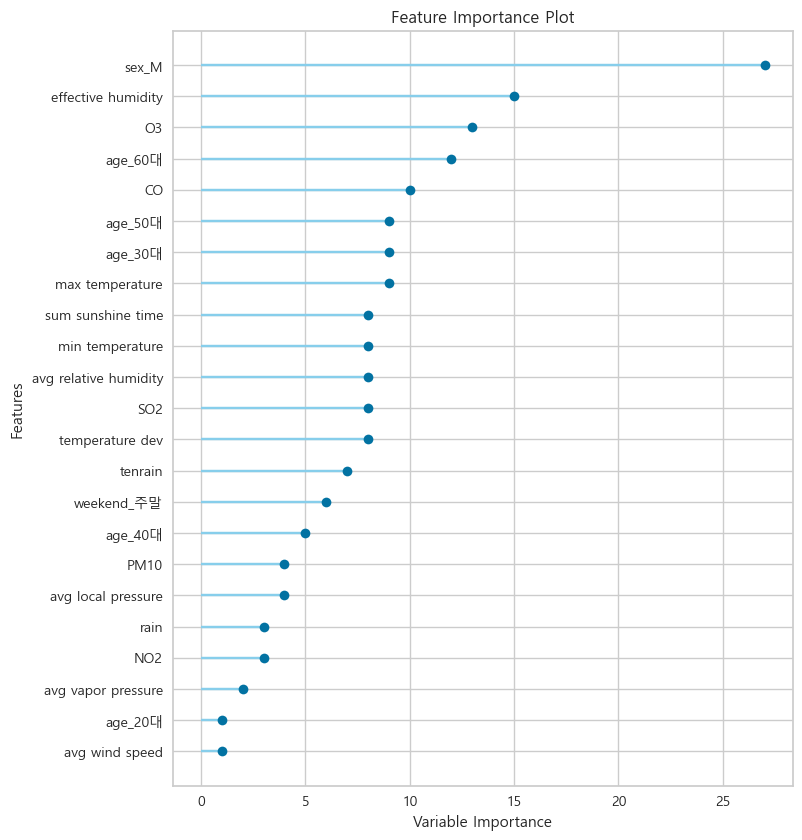

In [44]:
plot_model(model_lgbm, 'feature_all')

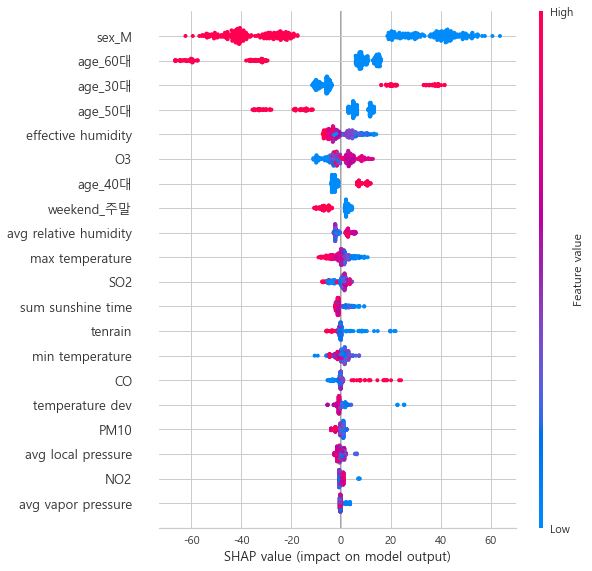

In [45]:
interpret_model(model_lgbm)